In [62]:
import numpy as np
import pandas as pd

In [145]:
df = pd.read_csv('messages.csv').dropna()
df['time'] = df["time"].astype("datetime64")
df.head()

,sender_name,time,content
0,Rafał Kulawiak,2012-03-05 14:21:34,będe chyba musiał sformatować komputer
1,Rafał Kulawiak,2012-03-05 14:20:54,nie ściągaj tego
2,Rafał Kulawiak,2012-03-05 14:20:52,sorry samo sie wysłało
3,Klaudia Sałamacha,2012-03-05 14:20:28,hei . Co to ?;]
4,Bartek Paszko,2013-10-22 18:48:40,ok narazie ;D


In [146]:
df = df[df['time'] > '2018-01-01']
my_df = df[df['sender_name'] == 'Bartek Paszko']
len(my_df)

72346

In [147]:
my_df.head()

,sender_name,time,content
359,Bartek Paszko,2019-03-09 18:07:16,o której mniej więcej?
360,Bartek Paszko,2019-03-09 18:07:09,"ok, thx za info"
362,Bartek Paszko,2019-03-04 21:16:33,Jest awizo
363,Bartek Paszko,2019-03-02 22:59:40,a dzisiaj rano ostatni raz sprawdzałem i nie b...
364,Bartek Paszko,2019-03-02 22:59:17,"jakiś czas temu przyszedł, ale to Darek wrócił..."


In [148]:
def analyse_xd(df):
    pattern = r'([xX]+[dD]+)'
    content = df['content']
    xds = df['content'].str.extractall(pattern)# .unstack() #.apply(','.join, 1)
    xds = xds.reset_index(drop=True)[0]
    return xds.value_counts(), xds.apply(lambda x: len(x)).mean()

In [178]:
from collections import Counter

def most_common_words(df, n=-1):
    c = Counter()
    
    def update_counter(msg):
        msg = msg.lower().translate(str.maketrans('', '' , ',."\'?!')).split(' ')
        c.update(msg)
        
    df['content'].apply(update_counter)
    return c if n == -1 else c.most_common(n)
    

In [150]:
def average_msg_len(df):
    lengths = df['content'].apply(lambda x: len(x))
    return lengths

In [165]:
def msg_per_hour(df):
    return df['time'].groupby(df["time"].dt.hour).count()

In [188]:
def swear_percent(df, swear_list):
    c = most_common_words(df)
    swears, total = 0, sum(c.values())
    for swear in swear_list:
        if swear in c:
            swears += c[swear]
    return swears / total

In [189]:
with open('wulgaryzmy.txt') as f:
    swear_list = f.read().split(' ')

swear_percent(my_df, swear_list)

0.012488972904851922

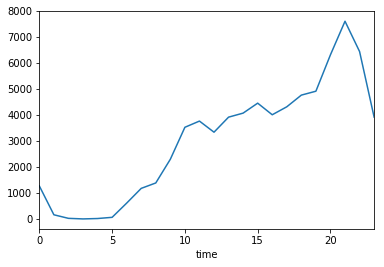

In [168]:
hist_hour = msg_per_hour(my_df)
hist_hour.plot()